In [67]:
import os
import gc
import time

import pyreadr as py
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import defaultdict

import torch
import torch.nn.functional as F

from torch import nn
from torch.optim import Adam, RMSprop
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from datetime import datetime

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

cuda:3


> ### Data downloading
Data link  
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/6C3JR1

##### Data description
Here we consoder dataset of "Additional Tennessee Eastman Process Simulation Data for Anomaly Detection Evaluation"
This dataverse contains the data referenced in Rieth et al. (2017). Issues and Advances in Anomaly Detection Evaluation for Joint Human-Automated Systems. To be presented at Applied Human Factors and Ergonomics 2017.
##### Columns description
* **faultNumber** ranges from 1 to 20 in the “Faulty” datasets and represents the fault type in the TEP. The “FaultFree” datasets only contain fault 0 (i.e. normal operating conditions).
* **simulationRun** ranges from 1 to 500 and represents a different random number generator state from which a full TEP dataset was generated (Note: the actual seeds used to generate training and testing datasets were non-overlapping).
* **sample** ranges either from 1 to 500 (“Training” datasets) or 1 to 960 (“Testing” datasets). The TEP variables (columns 4 to 55) were sampled every 3 minutes for a total duration of 25 hours and 48 hours respectively. Note that the faults were introduced 1 and 8 hours into the Faulty Training and Faulty Testing datasets, respectively.
* **columns 4-55** contain the process variables; the column names retain the original variable names.

In [2]:
# ! unzip ../../data/raw/dataverse_files.zip -d ../../data/raw/dataverse_files

In [3]:
#reading train data in .R format
a1 = py.read_r("../../data/raw/dataverse_files/TEP_FaultFree_Training.RData")
a2 = py.read_r("../../data/raw/dataverse_files/TEP_Faulty_Training.RData")

In [4]:
print("Objects that are present in a1 :", a1.keys())
print("Objects that are present in a2 :", a2.keys())
# print("Objects that are present in a3 :", a3.keys())
# print("Objects that are present in a4 :", a4.keys())

Objects that are present in a1 : odict_keys(['fault_free_training'])
Objects that are present in a2 : odict_keys(['faulty_training'])


In [5]:
# concatinating the train and the test dataset

raw_train = pd.concat([a1['fault_free_training'], a2['faulty_training']])

In [6]:
# 5.250.000, 10.080.000
len(raw_train)

5250000

> ### Train-test-split

In [7]:
features = [
        'xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8',
        'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 
        'xmeas_17', 'xmeas_18', 'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 
        'xmeas_25', 'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32',
        'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 
        'xmeas_41', 'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 
        'xmv_10', 'xmv_11'
    ]

In [8]:
raw_train['index'] = raw_train['faultNumber'] * 500 + raw_train['simulationRun'] - 1

In [9]:
simulation_idx = raw_train[['index', 'faultNumber']].drop_duplicates()

In [10]:
X_train_idx, X_val_idx = train_test_split(simulation_idx['index'], 
                                          stratify=simulation_idx['faultNumber'],
                                          test_size=0.2, 
                                          random_state=42)

In [11]:
X_train = raw_train[raw_train['index'].isin(X_train_idx)].drop('index', axis=1)
X_val = raw_train[raw_train['index'].isin(X_val_idx)].drop('index', axis=1)

> ### Scaling

In [12]:
scaler = StandardScaler()
scaler.fit(X_train[features])

X_train[features] = scaler.transform(X_train[features])
X_val[features] = scaler.transform(X_val[features])

> ### Dataset and dataloader

In [13]:
def correct(y_pred, target):
    
    y_pred = torch.softmax(y_pred, dim=1)
    y_pred = torch.max(y_pred, dim=1)[1]  
    
    return torch.eq(y_pred, target).sum().item()

In [14]:
class DataTEP(Dataset):

    def __init__(self, X, kind):
    
        self.X = X
        self.X = self.X.sort_values(['faultNumber', 'simulationRun', 'sample'])
        self.X['index'] = self.X.groupby(['faultNumber', 'simulationRun']).ngroup()
        self.X = self.X.set_index('index')
        
        self.max_length = self.X['sample'].max()

        if kind == 'train_val':
            self.s_list = [100]
            self.l_list = [100] # !!!!!
        else:
            self.s_list = [0]
            self.l_list = list(range(160, self.max_length + 1))
        
        self.features = [
                'xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8', 'xmeas_9', 
                'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 'xmeas_17', 
                'xmeas_18', 'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25', 
                'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32', 'xmeas_33', 
                'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 'xmeas_41', 
                'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 'xmv_10', 'xmv_11'
            ]

    def __len__(self):
        return self.X.index.nunique() * len(self.s_list) * len(self.l_list)
    
    def __getitem__(self, idx):
        
        fault_sim_idx = idx // (len(self.s_list) * len(self.l_list))
    
        start_length_idxs = idx % (len(self.s_list) * len(self.l_list))
        
        start_idx = self.s_list[start_length_idxs // len(self.l_list)]
        seq_length = self.l_list[start_length_idxs % len(self.l_list)]

        features = self.X.loc[fault_sim_idx][self.features].values[start_idx : (start_idx+seq_length), :]
        target = self.X.loc[fault_sim_idx]['faultNumber'].unique()[0]

        features = torch.tensor(features, dtype=torch.float)
        target = torch.tensor(target, dtype=torch.long)

        return features, target

In [15]:
BATCH_SIZE = 64
NUM_CLASSES = 21

In [16]:
def collate_fn(batch):

    sequences = [x[0] for x in batch]
    labels = [x[1] for x in batch]
        
    lengths = torch.LongTensor([len(x) for x in sequences])
    lengths, idx = lengths.sort(0, descending=True)
    
    sequences = [sequences[i] for i in idx]
    
    labels = torch.tensor(labels, dtype=torch.long)[idx]
    
    sequences_padded = pad_sequence(sequences, batch_first=True)

    return sequences_padded, lengths, labels

In [17]:
train_ds = DataTEP(X_train, kind='train_val')
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)

val_ds = DataTEP(X_val, kind='train_val')
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE*4, collate_fn=collate_fn)

# test_ds = DataTEP(X_test, kind='test')
# test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE*4, collate_fn=collate_fn)

In [18]:
len(train_ds), len(val_ds)
# len(test_ds)

(8400, 2100)

In [19]:
gc.collect()

0

> ### Models

In [20]:
class UniRNN(torch.nn.Module) :
    def __init__(self, RNN_TYPE, NUM_LAYERS, INPUT_SIZE, HIDDEN_SIZE, LINEAR_SIZE, OUTPUT_SIZE, BIDIRECTIONAL, DESCRIPTION):
        super().__init__()
        
        self.hidden_size = HIDDEN_SIZE
        self.num_layers = NUM_LAYERS
        self.input_size = INPUT_SIZE
        self.linear_size = LINEAR_SIZE
        self.output_size = OUTPUT_SIZE
        self.bidirectional = BIDIRECTIONAL
        self.description = DESCRIPTION
        
        rnn_cell = getattr(nn, RNN_TYPE)
        
        self.rnn = rnn_cell(
                        input_size=self.input_size, 
                        hidden_size=self.hidden_size,
                        num_layers=self.num_layers, 
                        bidirectional=self.bidirectional,
                        batch_first=True,
                        dropout=0.4
                )    
        
        self.head = nn.Sequential(
                        nn.Linear(in_features=self.hidden_size*(self.bidirectional+1), out_features=self.linear_size),
                        nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(in_features=self.linear_size, out_features=self.output_size),
                )
            
    def forward(self, x, x_length):
        
        x_packed = pack_padded_sequence(x, x_length, batch_first=True)
        
        x_rnn_out, _ = self.rnn(x_packed)
        
        x_unpacked, __ = pad_packed_sequence(x_rnn_out, batch_first=True)
        
        x = self.head(x_unpacked[:, -1])
        
        return x

In [21]:
class AttentionModel(torch.nn.Module):
    def __init__(self, RNN_TYPE, NUM_LAYERS, INPUT_SIZE, HIDDEN_SIZE, LINEAR_SIZE, OUTPUT_SIZE, BIDIRECTIONAL):
        super().__init__()
        
        self.hidden_size = HIDDEN_SIZE
        self.num_layers = NUM_LAYERS
        self.input_size = INPUT_SIZE
        self.linear_size = LINEAR_SIZE
        self.output_size = OUTPUT_SIZE
        self.bidirectional = BIDIRECTIONAL
        
        rnn_cell = getattr(nn, RNN_TYPE)

        self.rnn = rnn_cell(
                        input_size=self.input_size, 
                        hidden_size=self.hidden_size, 
                        num_layers=self.num_layers, 
                        bidirectional=self.bidirectional,
                        dropout=0.4,
                        batch_first=True
                )
        
        self.head = nn.Sequential(
#                         nn.Linear(in_features=self.hidden_size*(self.bidirectional+1), out_features=self.output_size),
                        nn.Linear(in_features=self.hidden_size*(self.bidirectional+1), out_features=self.linear_size),
                        nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(in_features=self.linear_size, out_features=self.output_size),
                )

    def attention(self, lstm_output):
        
        last_hidden = lstm_output[:, -1, :]
        attn_weights = torch.bmm(lstm_output, last_hidden.unsqueeze(2)).squeeze(2)
        
        soft_attn_weights = F.softmax(attn_weights, dim=1)
    
        new_hidden_state = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)

        return new_hidden_state
    
    def forward(self, x, x_length):

        x_packed = pack_padded_sequence(x, x_length, batch_first=True)
        
        x_rnn_out, _ = self.rnn(x_packed)
        
        x_unpacked, __ = pad_packed_sequence(x_rnn_out, batch_first=True)
        
        attention_out = self.attention(x_unpacked)
        x = self.head(attention_out)

        return x

In [22]:
class TransformerModel(torch.nn.Module):
    def __init__(self, NUM_LAYERS, INPUT_SIZE, HIDDEN_SIZE, LINEAR_SIZE, OUTPUT_SIZE, DROPOUT):
        super().__init__()
        
        self.hidden_size = HIDDEN_SIZE
        self.num_layers = NUM_LAYERS
        self.input_size = INPUT_SIZE
        self.linear_size = LINEAR_SIZE
        self.output_size = OUTPUT_SIZE
        self.dropout = DROPOUT

        
        transformer_encoder_layer = nn.TransformerEncoderLayer(
                        d_model=self.input_size, 
                        nhead=4, 
                        dim_feedforward=self.hidden_size, 
                        dropout=self.dropout, 
                        activation='relu'
                )
        
        
        self.transformer_encoder = nn.TransformerEncoder(
                        encoder_layer=transformer_encoder_layer, 
                        num_layers=self.num_layers, 
                        norm=None
                )
        
        self.weighted_mean = nn.Conv1d(
                        in_channels=self.input_size, 
                        out_channels=self.input_size, 
                        kernel_size=100, 
                        groups=self.input_size)
    
        self.head = nn.Sequential(
                        nn.Dropout(p=0.2),
                        nn.Linear(in_features=52, out_features=self.output_size),
#                         nn.Linear(in_features=52, out_features=self.linear_size),
#                         nn.ReLU(),
#                         nn.Dropout(p=0.4),
#                         nn.Linear(in_features=self.linear_size, out_features=self.output_size),
                )
    
    def forward(self, x, x_length=None):
        """
        src: (S, N, E) = (sequence_length, batch_size, n_features)
        src_key_padding_mask: (N, S) = (batch_size, sequence_length)
        """
    
        x_mask = torch.zeros(x.size(0), x.size(1), dtype=bool, device=x.device)
        
        for i in range(len(x)):
            x_mask[i, x_length[i]:] = True

        x = self.transformer_encoder(src=x.transpose(0, 1), src_key_padding_mask=x_mask)
        x = x.permute(1, 2, 0)
        x = self.weighted_mean(x)
        x = x.squeeze(-1)
        x = self.head(x)

        return x

In [27]:
NUM_EPOCHS = 50
LEARNING_RATE = 0.001

NUM_LAYERS = 2
HIDDEN_SIZE = 256
LINEAR_SIZE = 128
BIDIRECTIONAL = True

RNN_TYPE = "GRU"

> ### Model initialization

In [28]:
model = UniRNN(
            RNN_TYPE=RNN_TYPE, NUM_LAYERS=NUM_LAYERS, INPUT_SIZE=52, HIDDEN_SIZE=HIDDEN_SIZE, 
            LINEAR_SIZE=LINEAR_SIZE, OUTPUT_SIZE=NUM_CLASSES, BIDIRECTIONAL=BIDIRECTIONAL, 
            DESCRIPTION='simple_model_for_metrics'
        )

# model = AttentionModel(
#             RNN_TYPE=RNN_TYPE, NUM_LAYERS=NUM_LAYERS, INPUT_SIZE=52, HIDDEN_SIZE=HIDDEN_SIZE, 
#             LINEAR_SIZE=LINEAR_SIZE, OUTPUT_SIZE=NUM_CLASSES, BIDIRECTIONAL=BIDIRECTIONAL
#         )

# model = TransformerModel(NUM_LAYERS=6, INPUT_SIZE=52, HIDDEN_SIZE=128, LINEAR_SIZE=52, OUTPUT_SIZE=21, DROPOUT=0.4)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=25, gamma=0.5)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', verbose=True)

torch.manual_seed(42)
np.random.seed(42)

In [29]:
for i, (X_batch, X_lengths, y_batch) in enumerate(train_dl):
    if i < 1:
        print(type(X_batch), type(X_lengths), type(y_batch))
        print(len(X_batch), len(X_lengths), len(y_batch))
        print(X_lengths)
        X_batch, y_batch_train = X_batch.to(device), y_batch.to(device)
        y_pred_train = model(X_batch, X_lengths)
        print("y_batch_train.size()", y_batch.size())
        print("y_pred_train.size()", y_pred_train.size(), '\n')
    else:
        break

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
64 64 64
tensor([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100])
y_batch_train.size() torch.Size([64])
y_pred_train.size() torch.Size([64, 21]) 



In [30]:
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"model total parameters: {n_params}")
print(n_params / 1727253)

model total parameters: 1727253
1.0


In [31]:
# writer = SummaryWriter(comment=f'NL{NUM_LAYERS}_H{HIDDEN_SIZE}_L{LINEAR_SIZE}_B{BIDIRECTIONAL}_S{-100}')
writer = SummaryWriter(
    log_dir=f"metrics/{datetime.today().strftime('%d%b-%H-%M')}"
    )

In [32]:
ls metrics/

20May-10-35/  20May-10-59/  20May-17-03/
20May-10-39/  20May-15-59/  20May-17-54/


> ### Training

In [33]:
loss_train_all, loss_val_all = [], []
accuracy_train_all, accuracy_val_all = [], []

best_model_acc = 0
best_model_epoch = 0

for epoch in range(NUM_EPOCHS):

    start = time.time()
    print(f'Epoch: {epoch}, Learning Rate: {scheduler.get_last_lr()[0]}\n')

    loss_train_epoch, loss_val_epoch = 0, 0
    correct_train_epoch, correct_val_epoch = 0, 0
    n_train, n_val = 0, 0

    model.train()
    for (X_batch_train, X_batch_lengths_train, y_batch_train) in tqdm(train_dl):

        X_batch_train, X_batch_lengths_train, y_batch_train =\
                    X_batch_train.to(device), X_batch_lengths_train.to(device), y_batch_train.to(device)

        optimizer.zero_grad()
        y_pred_train = model(X_batch_train, X_batch_lengths_train)
        loss_train = criterion(y_pred_train, y_batch_train)
        loss_train.backward()
        optimizer.step()

        loss_train_epoch += loss_train.item() * y_batch_train.size()[0]
        correct_train_epoch += correct(y_pred_train, y_batch_train)
        n_train += y_batch_train.size()[0]

    scheduler.step()
    model.eval()

    with torch.no_grad():
        
#         for item in model.parameters():
#             print(item.grad.mean())
        
        for (X_batch_val, X_batch_lengths_val, y_batch_val) in tqdm(val_dl):

            X_batch_val, X_batch_lengths_val, y_batch_val =\
                    X_batch_val.to(device), X_batch_lengths_val.to(device), y_batch_val.to(device)

            y_pred_val = model(X_batch_val, X_batch_lengths_val)
            loss_val = criterion(y_pred_val, y_batch_val)
            
            loss_val_epoch += loss_val.item() * y_batch_val.size()[0]
            correct_val_epoch += correct(y_pred_val, y_batch_val)
            n_val += y_batch_val.size()[0]
            
    loss_mean_train_epoch = loss_train_epoch / n_train
    loss_mean_val_epoch = loss_val_epoch / n_val

    loss_train_all.append(loss_mean_train_epoch)
    loss_val_all.append(loss_mean_val_epoch)

    accuracy_train_epoch = correct_train_epoch / n_train
    accuracy_val_epoch = correct_val_epoch / n_val

    accuracy_train_all.append(accuracy_train_epoch)
    accuracy_val_all.append(accuracy_val_epoch)

    writer.add_scalars('LOSS per epoch', {"train": loss_mean_train_epoch, "val": loss_mean_val_epoch}, epoch)
    writer.add_scalars('ACCURACY per epoch', {"train": accuracy_train_epoch, "val": accuracy_val_epoch}, epoch)
    
    if accuracy_val_epoch > best_model_acc:
        
        best_model_state_dict = model.state_dict()
        best_model_acc = accuracy_val_epoch
        best_model_epoch = epoch
        
#     scheduler.step(loss_mean_val_epoch)
    
    end = time.time()
    print(f"epoch time: {end - start}")  
    print(f"mean loss train: {loss_mean_train_epoch}, mean loss val: {loss_mean_val_epoch}")
    print(f"accuracy train: {accuracy_train_epoch}, accuracy val: {accuracy_val_epoch}")

    print("---------------------------------------------------------------------------------------------------")

Epoch: 0, Learning Rate: 0.001




epoch time: 27.465468406677246
mean loss train: 1.5980033960796538, mean loss val: 0.8317041069978759
accuracy train: 0.4797619047619048, accuracy val: 0.6885714285714286
---------------------------------------------------------------------------------------------------
Epoch: 1, Learning Rate: 0.001




epoch time: 26.076239347457886
mean loss train: 0.7542745787756784, mean loss val: 0.569166464706262
accuracy train: 0.7105952380952381, accuracy val: 0.7495238095238095
---------------------------------------------------------------------------------------------------
Epoch: 2, Learning Rate: 0.001




epoch time: 25.242688179016113
mean loss train: 0.4476546047415052, mean loss val: 0.3506520317854094
accuracy train: 0.7971428571428572, accuracy val: 0.8176190476190476
---------------------------------------------------------------------------------------------------
Epoch: 3, Learning Rate: 0.001




epoch time: 25.20051097869873
mean loss train: 0.37978662808736163, mean loss val: 0.3308931863878388
accuracy train: 0.8054761904761905, accuracy val: 0.8195238095238095
---------------------------------------------------------------------------------------------------
Epoch: 4, Learning Rate: 0.001




epoch time: 25.394118309020996
mean loss train: 0.3426395352681478, mean loss val: 0.3258772005351438
accuracy train: 0.8254761904761905, accuracy val: 0.8219047619047619
---------------------------------------------------------------------------------------------------
Epoch: 5, Learning Rate: 0.001




epoch time: 25.230955123901367
mean loss train: 0.31923024853070575, mean loss val: 0.30057015736914416
accuracy train: 0.8348809523809524, accuracy val: 0.8438095238095238
---------------------------------------------------------------------------------------------------
Epoch: 6, Learning Rate: 0.001




epoch time: 25.164978981018066
mean loss train: 0.2880747944400424, mean loss val: 0.2762938633418526
accuracy train: 0.8539285714285715, accuracy val: 0.8566666666666667
---------------------------------------------------------------------------------------------------
Epoch: 7, Learning Rate: 0.001




epoch time: 25.34577775001526
mean loss train: 0.311913514477866, mean loss val: 0.3203130498386842
accuracy train: 0.8489285714285715, accuracy val: 0.8442857142857143
---------------------------------------------------------------------------------------------------
Epoch: 8, Learning Rate: 0.001




epoch time: 25.593859910964966
mean loss train: 0.3104800957725162, mean loss val: 0.27714718625659035
accuracy train: 0.8463095238095238, accuracy val: 0.8533333333333334
---------------------------------------------------------------------------------------------------
Epoch: 9, Learning Rate: 0.001




epoch time: 26.07008385658264
mean loss train: 0.274096280166081, mean loss val: 0.2686340416045
accuracy train: 0.8557142857142858, accuracy val: 0.8566666666666667
---------------------------------------------------------------------------------------------------
Epoch: 10, Learning Rate: 0.001




epoch time: 25.279330015182495
mean loss train: 0.2691631070205143, mean loss val: 0.2724669489406473
accuracy train: 0.8580952380952381, accuracy val: 0.8561904761904762
---------------------------------------------------------------------------------------------------
Epoch: 11, Learning Rate: 0.001




epoch time: 25.38720703125
mean loss train: 0.2671703181947981, mean loss val: 0.27019397758301195
accuracy train: 0.8621428571428571, accuracy val: 0.8652380952380953
---------------------------------------------------------------------------------------------------
Epoch: 12, Learning Rate: 0.001




epoch time: 25.69317889213562
mean loss train: 0.2685585216397331, mean loss val: 0.2682875210330669
accuracy train: 0.8611904761904762, accuracy val: 0.86
---------------------------------------------------------------------------------------------------
Epoch: 13, Learning Rate: 0.001




epoch time: 25.67712950706482
mean loss train: 0.2659841041337876, mean loss val: 0.27062467620485264
accuracy train: 0.8627380952380952, accuracy val: 0.8566666666666667
---------------------------------------------------------------------------------------------------
Epoch: 14, Learning Rate: 0.001




epoch time: 25.145289182662964
mean loss train: 0.26927756508191425, mean loss val: 0.2874352339336058
accuracy train: 0.861904761904762, accuracy val: 0.8542857142857143
---------------------------------------------------------------------------------------------------
Epoch: 15, Learning Rate: 0.001




epoch time: 26.52004861831665
mean loss train: 0.2738362711951846, mean loss val: 0.2662891685394962
accuracy train: 0.8608333333333333, accuracy val: 0.8733333333333333
---------------------------------------------------------------------------------------------------
Epoch: 16, Learning Rate: 0.001




epoch time: 26.489916801452637
mean loss train: 0.26578850212551297, mean loss val: 0.2618821895690261
accuracy train: 0.8678571428571429, accuracy val: 0.8666666666666667
---------------------------------------------------------------------------------------------------
Epoch: 17, Learning Rate: 0.001




epoch time: 25.855440378189087
mean loss train: 0.25952617526054383, mean loss val: 0.2774379844892645
accuracy train: 0.87, accuracy val: 0.8561904761904762
---------------------------------------------------------------------------------------------------
Epoch: 18, Learning Rate: 0.001




epoch time: 25.75890588760376
mean loss train: 0.2565099997747512, mean loss val: 0.31464756375267566
accuracy train: 0.8751190476190476, accuracy val: 0.8547619047619047
---------------------------------------------------------------------------------------------------
Epoch: 19, Learning Rate: 0.001




epoch time: 26.001506090164185
mean loss train: 0.26086235540253777, mean loss val: 0.23933758769715843
accuracy train: 0.8682142857142857, accuracy val: 0.8866666666666667
---------------------------------------------------------------------------------------------------
Epoch: 20, Learning Rate: 0.001




epoch time: 25.37575650215149
mean loss train: 0.2520586968603588, mean loss val: 0.2720040948050328
accuracy train: 0.8773809523809524, accuracy val: 0.8704761904761905
---------------------------------------------------------------------------------------------------
Epoch: 21, Learning Rate: 0.001




epoch time: 26.387458086013794
mean loss train: 0.25713650845346, mean loss val: 0.26095209462301033
accuracy train: 0.8759523809523809, accuracy val: 0.87
---------------------------------------------------------------------------------------------------
Epoch: 22, Learning Rate: 0.001




epoch time: 25.85945987701416
mean loss train: 0.24658110192843846, mean loss val: 0.23455050105139977
accuracy train: 0.8772619047619048, accuracy val: 0.8852380952380953
---------------------------------------------------------------------------------------------------
Epoch: 23, Learning Rate: 0.001




epoch time: 27.974095821380615
mean loss train: 0.25808985914502824, mean loss val: 0.267218602583515
accuracy train: 0.8727380952380952, accuracy val: 0.8595238095238096
---------------------------------------------------------------------------------------------------
Epoch: 24, Learning Rate: 0.001




epoch time: 25.64672017097473
mean loss train: 0.23693519189244225, mean loss val: 0.21534008253191825
accuracy train: 0.8845238095238095, accuracy val: 0.8938095238095238
---------------------------------------------------------------------------------------------------
Epoch: 25, Learning Rate: 0.0005




epoch time: 25.60823345184326
mean loss train: 0.20752970195951917, mean loss val: 0.1906708008334759
accuracy train: 0.8952380952380953, accuracy val: 0.8957142857142857
---------------------------------------------------------------------------------------------------
Epoch: 26, Learning Rate: 0.0005




epoch time: 26.544289350509644
mean loss train: 0.21617282470067342, mean loss val: 0.22675987595603234
accuracy train: 0.8908333333333334, accuracy val: 0.8938095238095238
---------------------------------------------------------------------------------------------------
Epoch: 27, Learning Rate: 0.0005




epoch time: 26.613383531570435
mean loss train: 0.1819418487378529, mean loss val: 0.19215839385986588
accuracy train: 0.9057142857142857, accuracy val: 0.9014285714285715
---------------------------------------------------------------------------------------------------
Epoch: 28, Learning Rate: 0.0005




epoch time: 26.009953022003174
mean loss train: 0.16879837615149362, mean loss val: 0.16190328416370384
accuracy train: 0.9125, accuracy val: 0.9195238095238095
---------------------------------------------------------------------------------------------------
Epoch: 29, Learning Rate: 0.0005




epoch time: 26.012330770492554
mean loss train: 0.14993105502355666, mean loss val: 0.4076265310105858
accuracy train: 0.9251190476190476, accuracy val: 0.8895238095238095
---------------------------------------------------------------------------------------------------
Epoch: 30, Learning Rate: 0.0005




epoch time: 25.416046857833862
mean loss train: 0.16806130800928387, mean loss val: 0.1358406248546886
accuracy train: 0.9180952380952381, accuracy val: 0.9328571428571428
---------------------------------------------------------------------------------------------------
Epoch: 31, Learning Rate: 0.0005




epoch time: 25.83914852142334
mean loss train: 0.12987855933961415, mean loss val: 0.15120525677998753
accuracy train: 0.9372619047619047, accuracy val: 0.9261904761904762
---------------------------------------------------------------------------------------------------
Epoch: 32, Learning Rate: 0.0005




epoch time: 26.20702314376831
mean loss train: 0.10500756272247859, mean loss val: 0.11756063801901616
accuracy train: 0.9444047619047619, accuracy val: 0.9352380952380952
---------------------------------------------------------------------------------------------------
Epoch: 33, Learning Rate: 0.0005




epoch time: 26.61406922340393
mean loss train: 0.10065187261218117, mean loss val: 0.11124960490635204
accuracy train: 0.9438095238095238, accuracy val: 0.9404761904761905
---------------------------------------------------------------------------------------------------
Epoch: 34, Learning Rate: 0.0005




epoch time: 26.897724628448486
mean loss train: 0.10124991848355248, mean loss val: 0.2367868221373785
accuracy train: 0.9439285714285715, accuracy val: 0.9004761904761904
---------------------------------------------------------------------------------------------------
Epoch: 35, Learning Rate: 0.0005




epoch time: 25.791513204574585
mean loss train: 0.11292461270377749, mean loss val: 0.10895588670458285
accuracy train: 0.9391666666666667, accuracy val: 0.9404761904761905
---------------------------------------------------------------------------------------------------
Epoch: 36, Learning Rate: 0.0005




epoch time: 27.140514850616455
mean loss train: 0.09338969846566518, mean loss val: 0.10128650540397627
accuracy train: 0.9472619047619047, accuracy val: 0.9423809523809524
---------------------------------------------------------------------------------------------------
Epoch: 37, Learning Rate: 0.0005




epoch time: 25.994311571121216
mean loss train: 0.08009093383948009, mean loss val: 0.11671449683961414
accuracy train: 0.9501190476190476, accuracy val: 0.9385714285714286
---------------------------------------------------------------------------------------------------
Epoch: 38, Learning Rate: 0.0005




epoch time: 25.743436336517334
mean loss train: 0.08836447446119218, mean loss val: 0.10750235671089069
accuracy train: 0.9517857142857142, accuracy val: 0.9419047619047619
---------------------------------------------------------------------------------------------------
Epoch: 39, Learning Rate: 0.0005




epoch time: 25.70450496673584
mean loss train: 0.08591595019612994, mean loss val: 0.1334789105823854
accuracy train: 0.9486904761904762, accuracy val: 0.9304761904761905
---------------------------------------------------------------------------------------------------
Epoch: 40, Learning Rate: 0.0005




epoch time: 26.57678985595703
mean loss train: 0.08217488808291298, mean loss val: 0.12462643078395272
accuracy train: 0.9476190476190476, accuracy val: 0.94
---------------------------------------------------------------------------------------------------
Epoch: 41, Learning Rate: 0.0005




epoch time: 26.399455070495605
mean loss train: 0.08149320131256467, mean loss val: 0.09250520978655118
accuracy train: 0.9504761904761905, accuracy val: 0.9466666666666667
---------------------------------------------------------------------------------------------------
Epoch: 42, Learning Rate: 0.0005




epoch time: 25.985329389572144
mean loss train: 0.07610267497244336, mean loss val: 0.09722053754897214
accuracy train: 0.9529761904761904, accuracy val: 0.9414285714285714
---------------------------------------------------------------------------------------------------
Epoch: 43, Learning Rate: 0.0005




epoch time: 26.381378412246704
mean loss train: 0.08043639393079849, mean loss val: 0.11110239823659153
accuracy train: 0.9507142857142857, accuracy val: 0.9380952380952381
---------------------------------------------------------------------------------------------------
Epoch: 44, Learning Rate: 0.0005




epoch time: 25.816885232925415
mean loss train: 0.07338382437115624, mean loss val: 0.12577339967091858
accuracy train: 0.9542857142857143, accuracy val: 0.9385714285714286
---------------------------------------------------------------------------------------------------
Epoch: 45, Learning Rate: 0.0005




epoch time: 26.227526426315308
mean loss train: 0.07337363688718705, mean loss val: 0.1042516388211938
accuracy train: 0.9561904761904761, accuracy val: 0.9423809523809524
---------------------------------------------------------------------------------------------------
Epoch: 46, Learning Rate: 0.0005




epoch time: 26.389192581176758
mean loss train: 0.07307790971937633, mean loss val: 0.11124235380263123
accuracy train: 0.9527380952380953, accuracy val: 0.9404761904761905
---------------------------------------------------------------------------------------------------
Epoch: 47, Learning Rate: 0.0005




epoch time: 25.716917037963867
mean loss train: 0.08750187087626685, mean loss val: 0.09330391293480976
accuracy train: 0.9503571428571429, accuracy val: 0.9438095238095238
---------------------------------------------------------------------------------------------------
Epoch: 48, Learning Rate: 0.0005




epoch time: 27.021966218948364
mean loss train: 0.08740314968994685, mean loss val: 0.10778044609796303
accuracy train: 0.9484523809523809, accuracy val: 0.9366666666666666
---------------------------------------------------------------------------------------------------
Epoch: 49, Learning Rate: 0.0005




epoch time: 25.22649049758911
mean loss train: 0.08407136190505254, mean loss val: 0.09097373451505389
accuracy train: 0.9488095238095238, accuracy val: 0.9414285714285714
---------------------------------------------------------------------------------------------------


> ### Loading best model

In [61]:
! ls models/

model


In [57]:
torch.save(best_model_state_dict, "models/model")

In [34]:
model.load_state_dict(best_model_state_dict)
model = model.to(device)
model.eval()

UniRNN(
  (rnn): GRU(52, 256, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (head): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=128, out_features=21, bias=True)
  )
)

> ### Val evaluation

In [35]:
def get_metrics(y_true, y_pred):
    
    """
    Calculates TPR, FPR and ACCURACY per class for multiple simulation runs

    Parameters
    ----------
    y_true : 
        type: np.array 
        shape : (number of simulation runs)
        description: true classes for simulation runs
    
    y_pred : np.array
    
        type: np.array 
        shape : (number of simulation runs)
        description: predicted classes for simulation runs
        
    Returns
    -------
    TPR : 
        type: list of floats
        shape: (number of classes)
        description: True Positive Rate per class
    FPR : 
        type: list of floats
        shape: (number of classes)
        description: False Positive Rate per class
    ACCURACY : 
        type: list of floats
        shape: (number of classes)
        description: Accuracy "one vs all" per class
    """
    
    conf = confusion_matrix(y_true, y_pred)
    
    FP = conf.sum(axis=0) - np.diag(conf)
    FN = conf.sum(axis=1) - np.diag(conf)
    TP = np.diag(conf)
    TN = conf.sum() - (FP + FN + TP)
    
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)

    ACCURACY = (TP + TN) / (TP + TN + FP + FN)
    
    return TPR, FPR, ACCURACY

In [36]:
def get_first_true_idx(arr):
    idx = np.where(arr == True)[0]
    if len(idx) == 0:
        return np.NaN
    else:
        return idx.min()

def get_detection_delay(y_true, y_pred) -> dict():
    """
    Calculates TPR, FPR and ACCURACY per class for multiple simulation runs

    Parameters
    ----------
    y_true : 
        type : np.array 
        shape : (number of simulation runs)
        description : true classes for simulation runs
    
    y_pred : np.array 
        type : np.array 
        shape : (number of simulation runs, simulation runs' lengths)
        description: predicted classes for every sample for every simulation runs
        
    Returns
    -------
    detection_delay :
        type : dict
        keys : classes from 0 to 20
        description : dict of detection delays for every class, nan means true class wasn't predicted
    
    Commentary:
        If you want to get avarage detection delays per class, you need to calulate avg of detection_delay[key]
        for every key 
        
    """
    
    detection_delay = defaultdict(list)
    
    correct = y_pred == y_true[..., np.newaxis]
    first_true_idxs = np.apply_along_axis(func1d=get_first_true_idx, arr=correct, axis=1)

    for (cls, idx) in zip(y_true, first_true_idxs):
        detection_delay[cls].append(idx)
    return detection_delay

In [94]:
def plotting(arr, name, forward=True):
    classes = np.arange(len(arr))

    norm = plt.Normalize(arr.min(), arr.max())
    
    if forward:
        colors = plt.cm.RdYlGn(norm(arr))
    else:
        colors = plt.cm.summer(norm(arr))
        
    plt.figure(figsize=(8, 5))
    plt.title(f'{name} per class')
    sns.barplot(x=classes, y=arr, palette=colors)
    plt.xticks(classes, ["fault_" + str(c) if c > 0 else "normal" for c in classes], rotation=90)
    plt.xlabel('class')
    plt.ylabel(f'{name}')
    plt.ylim(0, 1.1)
    plt.show()

In [38]:
model.eval()

y_ans_val, y_true_val = [], []

with torch.no_grad():

    for (X_batch_val, X_batch_lengths_val, y_batch_val) in tqdm(val_dl):

        X_batch_val, X_batch_lengths_val, y_batch_val =\
                    X_batch_val.to(device), X_batch_lengths_val.to(device), y_batch_val.to(device)

        y_pred_val = model(X_batch_val, X_batch_lengths_val)
        
        y_pred_prob = F.softmax(y_pred_val.cpu(), dim=-1)
        y_pred_class = y_pred_prob.max(dim=-1)[1]
       
        y_ans_val += y_pred_class.tolist()
        y_true_val += y_batch_val.tolist()

In [39]:
# plt.figure(figsize=(20, 8))
# plt.title("loss")
# plt.plot(np.arange(len(loss_train_all)), loss_train_all, '-o', marker='.', label='train')
# plt.plot(np.arange(len(loss_val_all)), loss_val_all, '-o', marker='.', label='val')
# plt.legend()
# plt.show()

In [40]:
# plt.figure(figsize=(20, 8))
# plt.title("accuracy")
# plt.plot(np.arange(len(accuracy_train_all)), accuracy_train_all, '-o', marker='.', label='train')
# plt.plot(np.arange(len(accuracy_val_all)), accuracy_val_all, '-o', marker='.', label='val')
# plt.text(35, 0.65, s=f"best acc: {best_model_acc}\nbest epoch: {best_model_epoch}", fontsize=20)
# plt.scatter(best_model_epoch, best_model_acc, c='g', s=100)
# plt.legend()
# plt.show()

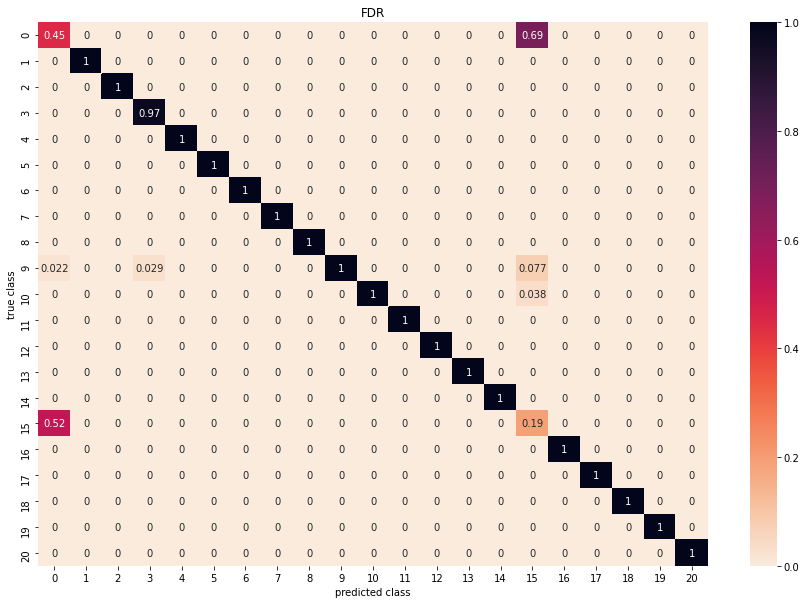

In [41]:
plt.figure(figsize=(15, 10))
plt.title("FDR")
sns.heatmap(confusion_matrix(y_true_val, y_ans_val, normalize='pred'), annot=True, cmap=sns.cm.rocket_r)
plt.xlabel('predicted class')
plt.ylabel('true class')
plt.show()

In [42]:
TPR, FPR, ACCURACY = get_metrics(y_true_val, y_ans_val)

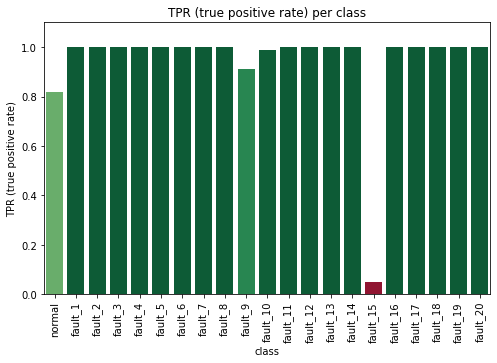

In [43]:
plotting(TPR, "TPR (true positive rate)")

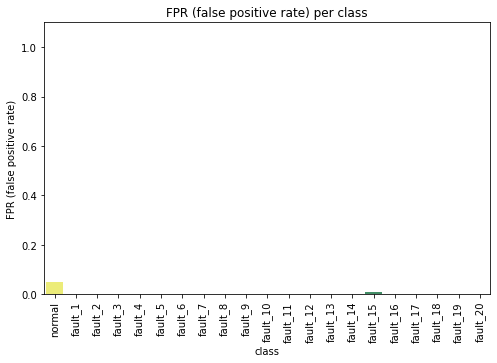

In [44]:
plotting(FPR, "FPR (false positive rate)", forward=False)

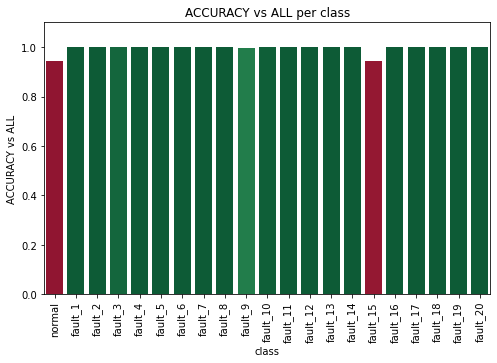

In [45]:
plotting(ACCURACY, "ACCURACY vs ALL")

> ### Test evaluation

In [46]:
gc.collect()

45357

In [47]:
#reading test data in .R format
a3 = py.read_r("../../data/raw/dataverse_files/TEP_FaultFree_Testing.RData")
a4 = py.read_r("../../data/raw/dataverse_files/TEP_Faulty_Testing.RData")

raw_test = pd.concat([a3['fault_free_testing'], a4['faulty_testing']])

In [48]:
raw_test[features] = scaler.transform(raw_test[features])

In [49]:
raw_test['index'] = raw_test['faultNumber'] * 500 + raw_test['simulationRun'] - 1
raw_test = raw_test.set_index('index')

In [50]:
raw_test.head()

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
index,,,,,,,,,,,,,,,,,,,,,
0.0,0,1.0,1,-0.061905,0.201545,-0.366697,0.396960,0.672885,0.349442,-0.223455,...,0.036876,-0.280430,-0.477229,-0.047406,0.017518,0.678059,0.641891,-0.185190,0.014966,-0.693145
0.0,0,1.0,2,-0.057595,-0.504438,0.575905,0.124438,0.421859,0.709238,-0.228836,...,-0.201046,-0.283523,-0.372900,-0.042150,0.002242,-0.482106,-0.595256,-0.173439,-0.142419,-0.548871
0.0,0,1.0,3,-0.084550,-0.483398,0.012553,-0.222560,0.110240,-0.271443,-0.251702,...,-0.059070,-0.263817,-0.348612,-0.062236,0.011582,1.286104,-0.800952,-0.174777,-0.062251,0.333051
0.0,0,1.0,4,-0.063137,-0.829377,0.121173,-0.098154,0.421859,-0.105874,-0.246322,...,-0.086261,-0.279133,-0.173902,-0.082698,0.016885,0.675348,0.681334,-0.177046,-0.119325,-0.335875
0.0,0,1.0,5,-0.295060,-0.186512,0.597077,-0.170677,-0.002289,0.123376,-0.195209,...,-0.193666,-0.417724,-0.176248,-0.042244,-0.176629,0.075099,-0.747937,-0.171810,-0.087889,-0.022812


In [63]:
class DataTEST(Dataset):

    def __init__(self, X, seq_length):
    
        self.X = X
        self.seq_length = seq_length
        
        self.features = [
                'xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8', 'xmeas_9', 
                'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 'xmeas_17', 
                'xmeas_18', 'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25', 
                'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32', 'xmeas_33', 
                'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 'xmeas_41', 
                'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 'xmv_10', 'xmv_11'
            ]

    def __len__(self):
        return self.X.index.nunique()
    
    def __getitem__(self, idx):

        features = self.X.loc[idx][self.features].values[160 : (161+self.seq_length), :]
        target = self.X.loc[idx]['faultNumber'].unique()[0]

        features = torch.tensor(features, dtype=torch.float)
        target = torch.tensor(target, dtype=torch.long)

        return features, target

In [64]:
%%time

SEQ_LENGTH = [5, 25, 50, 100]
metrics = dict()
y_ans_test_all = []

for seq_length in SEQ_LENGTH:
    
    y_ans_test, y_true_test = [], []
    
    test_ds = DataTEST(raw_test, seq_length=seq_length)
    test_dl = DataLoader(test_ds, batch_size=512)

    start = time.time()
    print(f'seq_length: {seq_length}\n')

    model.eval()
    for (X_batch_test, y_batch_test) in tqdm(test_dl):
        
        print(X_batch_test.size())
        
        X_batch_lengths_test = torch.tensor([seq_length]*len(X_batch_test)).to(device)

        X_batch_test, y_batch_test = X_batch_test.to(device), y_batch_test.to(device)

        y_pred_test = model(X_batch_test, X_batch_lengths_test)

        y_pred_prob = F.softmax(y_pred_test.cpu(), dim=-1)
        y_pred_class = y_pred_prob.max(dim=-1)[1]
       
        y_ans_test += y_pred_class.tolist()
        y_true_test += y_batch_test.tolist()
        
        end = time.time()
        
    y_ans_test_all.append(y_ans_test)
        
    TPR, FPR, ACCURACY = get_metrics(y_true_test, y_ans_test)
    
#     print("Classes True", round(pd.Series(y_true_test).value_counts(normalize=True).sort_index(), 4).to_dict())
#     print("Classes False", round(pd.Series(y_ans_test).value_counts(normalize=True).sort_index(), 4).to_dict())
    
#     print("TPR", np.round(TPR, 4))
#     print("FPR", np.round(FPR, 4))
#     print("ACCURACY", np.round(ACCURACY, 4))
    
    metrics[seq_length] = [TPR, FPR, ACCURACY]
    
    print(f"seq_length time: {end - start}")  

seq_length: 5



torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([512, 6, 52])
torch.Size([260, 6, 52])

seq_length time: 266.90262722969055
seq_length: 25



torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([512, 26, 52])
torch.Size([260, 26, 52])

seq_length time: 267.2626962661743
seq_length: 50



torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([512, 51, 52])
torch.Size([260, 51, 52])

seq_length time: 267.2611970901489
seq_length: 100



torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([512, 101, 52])
torch.Size([260, 101, 52])

seq_length time: 269.3154339790344
CPU times: user 17min 57s, sys: 2.34 s, total: 17min 59s
Wall time: 17min 50s


In [65]:
y_ans_test_all = np.array(y_ans_test_all).T
y_true_test_all = np.array(y_true_test).T

y_ans_test_all.shape, y_true_test_all.shape

((10500, 4), (10500,))

In [68]:
detection_delay = get_detection_delay(y_true=y_true_test_all, y_pred=y_ans_test_all)

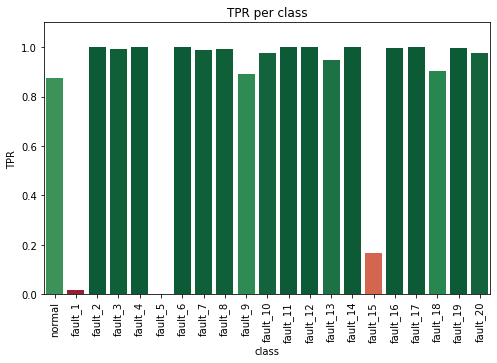

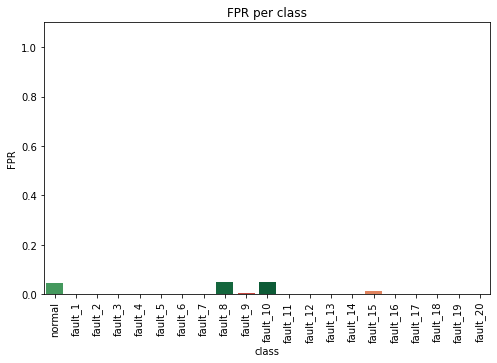

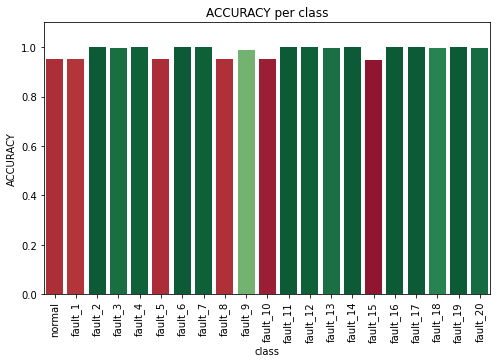

In [87]:
plotting(metrics[seq_length][0], "TPR")
plotting(metrics[seq_length][1], "FPR")
plotting(metrics[seq_length][2], "ACCURACY")

In [71]:
detection_delay_mean = {}
for (k, v) in detection_delay.items():
    detection_delay_mean[k] = np.nanmean(v)

/home/mark.lyubimov/.local/share/virtualenvs/tep-EqsBjobE/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [79]:
detection_delay_mean

{0: 1.3165618448637317,
 1: 3.0,
 2: 3.0,
 3: 0.8072289156626506,
 4: 0.008,
 5: nan,
 6: 1.458,
 7: 2.985858585858586,
 8: 1.7008032128514057,
 9: 0.6242171189979123,
 10: 1.9386503067484662,
 11: 1.19,
 12: 1.252,
 13: 2.522105263157895,
 14: 0.178,
 15: 1.4918032786885247,
 16: 1.559118236472946,
 17: 1.998,
 18: 2.5508849557522124,
 19: 0.816,
 20: 2.574642126789366}

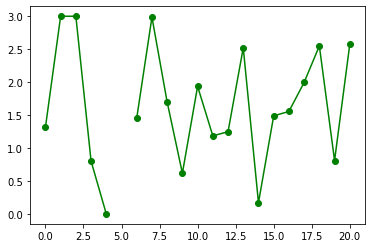

In [97]:
plt.plot(np.array(list(detection_delay_mean.values())), '-go')
plt.show()

In [ ]:
class TwinModel(torch.nn.Module) :
    def __init__(self, NUM_LAYERS, INPUT_SIZE, HIDDEN_SIZE, LINEAR_SIZE, OUTPUT_SIZE, BIDIRECTIONAL, DEVICE):
        super().__init__()
        
        self.hidden_size = HIDDEN_SIZE
        self.num_layers = NUM_LAYERS
        self.input_size = INPUT_SIZE
        self.linear_size = LINEAR_SIZE
        self.output_size = OUTPUT_SIZE
        self.bidirectional = BIDIRECTIONAL
        
        self.lstm_1 = nn.LSTM(
                        input_size=self.input_size[0], 
                        hidden_size=self.hidden_size,
                        num_layers=self.num_layers, 
                        bidirectional=self.bidirectional,
                        batch_first=True,
                        dropout=0.4
            )
        
        self.lstm_2 = nn.LSTM(
                        input_size=self.input_size[1],
                        hidden_size=self.hidden_size,
                        num_layers=self.num_layers, 
                        bidirectional=self.bidirectional,
                        batch_first=True,
                        dropout=0.4
            )
        
        
        self.head = nn.Sequential(
                        nn.Linear(in_features=2*self.hidden_size*(self.bidirectional+1), out_features=self.linear_size),
                        nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(in_features=self.linear_size, out_features=OUTPUT_SIZE),
            )
        
    def forward(self, x):
        
        x_1 = x[:, :, :41]
        x_2 = x[:, :, 41:]
        
        x_1, _ = self.lstm_1(x_1)
        x_2, __ = self.lstm_2(x_2)
        
        x_3 = torch.cat((x_1[:, -1], x_2[:, -1]), dim=-1)
        
        x = self.head(x_3)
        
        return x